## Imports

In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, roc_curve, auc, roc_auc_score, classification_report, confusion_matrix
import re
from collections import defaultdict
from torch.utils.data import Dataset
from sklearn.preprocessing import LabelEncoder
from datetime import datetime
from xgboost import XGBClassifier
from sklearn.preprocessing import label_binarize
import os
from tqdm import tqdm
import shap
import pandas as pd
import numpy as np
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from collections import Counter


## Data preprocessing

In [ ]:
def apply_smote(labeled_x, labeled_y, random_state=42):
    """
    Applies SMOTE oversampling to balance class distribution in labeled data.

    Args:
        labeled_x (np.ndarray): Feature array of shape (n_samples, ...) for labeled data.
        labeled_y (np.ndarray): Corresponding class labels.
        random_state (int): Random seed for reproducibility.

    Returns:
        X_resampled (np.ndarray): Resampled feature array in original shape.
        y_resampled (np.ndarray): Resampled labels.
    """
    print("Original class distribution:", Counter(labeled_y))

    X = labeled_x.reshape((labeled_x.shape[0], -1))

    smote = SMOTE(random_state=random_state)
    X_resampled, y_resampled = smote.fit_resample(X, labeled_y)

    print("Resampled class distribution:", Counter(y_resampled))

    original_shape = labeled_x.shape[1:]
    X_resampled = X_resampled.reshape((X_resampled.shape[0],) + original_shape)

    return X_resampled, y_resampled

def find_knn_per_class(
    labeled_x, labeled_y,
    unlabeled_x, unlabeled_meta=None,
    target_class=0,
    max_K=10,
    distance_threshold=50
):
    """
    For labeled samples of a given class, find up to max_K neighbors in unlabeled_x
    that are within distance_threshold. Avoids reuse and removes neighbors from unlabeled pool.

    Returns:
    - results: list of neighbor info per labeled sample
    - new_labeled_x: np.ndarray of new samples
    - new_labeled_y: np.ndarray of pseudo-labels (same as target_class)
    - updated_unlabeled_x: np.ndarray of unlabeled_x with selected neighbors removed
    - updated_unlabeled_meta: same shape as unlabeled_meta (if given), else None
    """
    class_mask = labeled_y == target_class
    class_x = labeled_x[class_mask]
    class_indices = np.where(class_mask)[0]

    if len(unlabeled_x) == 0:
        return [], np.empty((0, labeled_x.shape[1])), np.array([]), unlabeled_x, unlabeled_meta

    nn = NearestNeighbors(n_neighbors=min(max_K * 3, len(unlabeled_x)), metric='euclidean')
    nn.fit(unlabeled_x)

    results = []
    neighbor_data = []
    neighbor_labels = []
    used_indices = set()

    for l_idx, sample in zip(class_indices, class_x):
        dists, nbrs = nn.kneighbors(sample.reshape(1, -1), return_distance=True)
        dists = dists[0]
        nbrs = nbrs[0]

        selected = [(i, d) for i, d in zip(nbrs, dists)
                    if 0 < d <= distance_threshold and i not in used_indices]

        if selected:
            selected = selected[:max_K]
            sel_indices, sel_dists = zip(*selected)
            used_indices.update(sel_indices)

            neighbor_data.append(unlabeled_x[list(sel_indices)])
            neighbor_labels.append(np.full(len(sel_indices), target_class))

            results.append({
                'labeled_index': l_idx,
                'labeled_sample': sample,
                'neighbor_indices': sel_indices,
                'distances': sel_dists
            })

    if neighbor_data:
        new_labeled_x = np.vstack(neighbor_data)
        new_labeled_y = np.concatenate(neighbor_labels)
    else:
        new_labeled_x = np.empty((0, labeled_x.shape[1]))
        new_labeled_y = np.array([])

    used_indices = sorted(used_indices)
    mask = np.ones(len(unlabeled_x), dtype=bool)
    mask[used_indices] = False
    updated_unlabeled_x = unlabeled_x[mask]

    if unlabeled_meta is not None:
        updated_unlabeled_meta = unlabeled_meta[mask]
    else:
        updated_unlabeled_meta = None

    return results, new_labeled_x, new_labeled_y, updated_unlabeled_x, updated_unlabeled_meta


In [124]:
class LabeledAcousticDataset(Dataset):
    def __init__(self, base_folder, feature_columns=None, id_columns=('File', 'Minute', 'Time')):
        self.base_folder = base_folder
        self.id_columns = id_columns
        self.feature_columns = feature_columns or [
            'ClksThisMin', 'NofClx', 'medianKHz', 'avSPL', 'avPkAt', 'AvPRF', 'avEndF',
            'tWUTrisk', 'nActualClx', 'nRisingIPIs', 'TrDur_us', 'nICIrising',
            'MinICI_us', 'midpointICI', 'MaxICI_us', 'ClkNofMinICI', 'ClkNofMaxICI',
            'NofClstrs', 'avClstrNx8', 'avPkIPI', 'BeforeIPIratio', 'PreIPIratio',
            'Post1IPIratio', 'Post2IPIratio', 'EndIPIratio'
        ]

        self.labeled_data, self.labels = self._load_all_labeled_data()

    def _load_all_labeled_data(self):
        labeled_data = []
        labels = []

        label_map = {
            "FeedingBuzzes": 0,
            "NonFeedingClickTrains": 1
        }

        for class_folder, label in label_map.items():
            folder_path = os.path.join(self.base_folder, class_folder)
            excel_file = os.path.join(folder_path, f"{class_folder}.xlsx")

            if not os.path.exists(excel_file):
                raise FileNotFoundError(f"Excel file not found: {excel_file}")

            df = pd.read_excel(excel_file)

            # Ensure alignment with ID columns
            df[self.id_columns[0]] = df[self.id_columns[0]].astype(str)
            df[self.id_columns[1]] = df[self.id_columns[1]].astype(int)
            df[self.id_columns[2]] = df[self.id_columns[2]].astype(int)

            df['label'] = label
            labeled_data.append(df)
            labels.extend([label] * len(df))

        full_df = pd.concat(labeled_data, ignore_index=True)

        return full_df, np.array(labels, dtype=np.int64)

    def get_labeled(self):
        df = self.labeled_data[self.feature_columns].apply(
            lambda col: col.astype(str).str.replace(',', '.').astype(np.float32)
        )

        X = df.to_numpy()
        y = self.labels
        meta = self.labeled_data[['File', 'Minute', 'Time']].values

        return X, y, meta

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        row = self.labeled_data.iloc[idx]
        features = row[self.feature_columns].astype(str).str.replace(',', '.').astype(np.float32).to_numpy()
        label = self.labels[idx]
        return features, label

dataset = LabeledAcousticDataset("new click trains (Bulgaria)")
test_x, test_y, test_meta = dataset.get_labeled()

print(f"Labeled samples: {len(test_x)}")


Labeled samples: 64


In [125]:
special_areas = ['U Dzha Bay', 'U Dzha Sea']

signal_meta = np.array(test_meta)
def extract_area_name(entry):
    entry_str = str(entry)
    for area in special_areas:
        if entry_str.startswith(area):
            return area
    match = re.match(r'^(\w+ \w+)', entry_str)
    return match.group(1) if match else entry_str

vectorized_extractor = np.vectorize(extract_area_name)

clean_unlabeled_meta = vectorized_extractor(signal_meta[:, 0])
test_meta = np.column_stack((clean_unlabeled_meta, signal_meta[:, 1:3]))

In [126]:
data = np.load("data_files/full_acoustic_dataset.npz", allow_pickle=True)
labeled_x = data['labeled_x']
labeled_y = data['labeled_y']
unlabeled_x = data['unlabeled_x']
unlabeled_meta = data['unlabeled_meta']
labeled_meta = data['labeled_meta']


In [127]:
# === Pseudo-labeling from training set only ===
all_new_x = []
all_new_y = []

for cls in np.unique(labeled_y):
    results, new_x, new_y, unlabeled_x, unlabeled_meta = find_knn_per_class(
        labeled_x, labeled_y,
        unlabeled_x, unlabeled_meta,
        target_class=cls,
        max_K=10,
        distance_threshold=500
    )
    print(f"Class {cls}: added {len(new_y)} new samples.")
    all_new_x.append(new_x)
    all_new_y.append(new_y)

pseudo_x = np.vstack(all_new_x)
pseudo_y = np.concatenate(all_new_y)

print("Final up-sampled size:", pseudo_x.shape)
print("Remaining unlabeled:", unlabeled_x.shape)

# === Combine and apply SMOTE ===
all_train_x = np.concatenate([labeled_x, pseudo_x])
all_train_y = np.concatenate([labeled_y, pseudo_y])

print("Original class distribution:", Counter(all_train_y))
X_resampled, y_resampled = apply_smote(all_train_x, all_train_y)
print("Resampled class distribution:", Counter(y_resampled))

Class 0: added 129 new samples.
Class 1: added 2733 new samples.
Final up-sampled size: (2862, 25)
Remaining unlabeled: (13141621, 25)
Original class distribution: Counter({np.int64(1): 3061, np.int64(0): 302})
Original class distribution: Counter({np.int64(1): 3061, np.int64(0): 302})
Resampled class distribution: Counter({np.int64(0): 3061, np.int64(1): 3061})
Resampled class distribution: Counter({np.int64(0): 3061, np.int64(1): 3061})


## Random forest

In [128]:
rf_model = RandomForestClassifier(
    n_estimators=50,
    max_depth=10,
    class_weight='balanced',
    random_state=42
)
rf_model.fit(X_resampled, y_resampled)

probs = rf_model.predict_proba(test_x)
preds = rf_model.predict(test_x)

print("Evaluation:")
print(f"Accuracy: {accuracy_score(test_y, preds):.4f}")
print(f"F1 Score (macro): {f1_score(test_y, preds, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(test_y, preds, average='weighted'):.4f}")

Evaluation:
Accuracy: 0.8438
F1 Score (macro): 0.8068
F1 Score (weighted): 0.8332


In [129]:
print("\nPer-Class Classification Report:")
print(classification_report(test_y, preds, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(test_y, preds))



Per-Class Classification Report:
              precision    recall  f1-score   support

           0     0.9286    0.5909    0.7222        22
           1     0.8200    0.9762    0.8913        42

    accuracy                         0.8438        64
   macro avg     0.8743    0.7835    0.8068        64
weighted avg     0.8573    0.8438    0.8332        64

Confusion Matrix:
[[13  9]
 [ 1 41]]


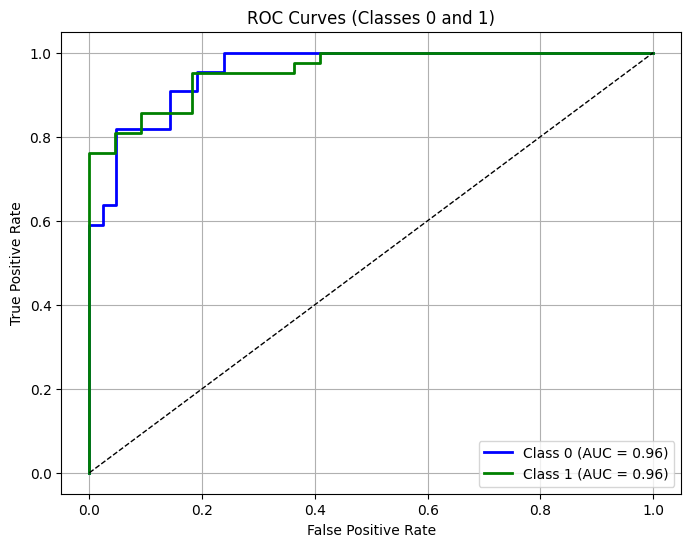

In [130]:
y_bin = label_binarize(test_y, classes=[0, 1])
if y_bin.shape[1] == 1:
    y_bin = np.hstack((1 - y_bin, y_bin))
fpr = {}
tpr = {}
roc_auc = {}

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'green']
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Classes 0 and 1)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


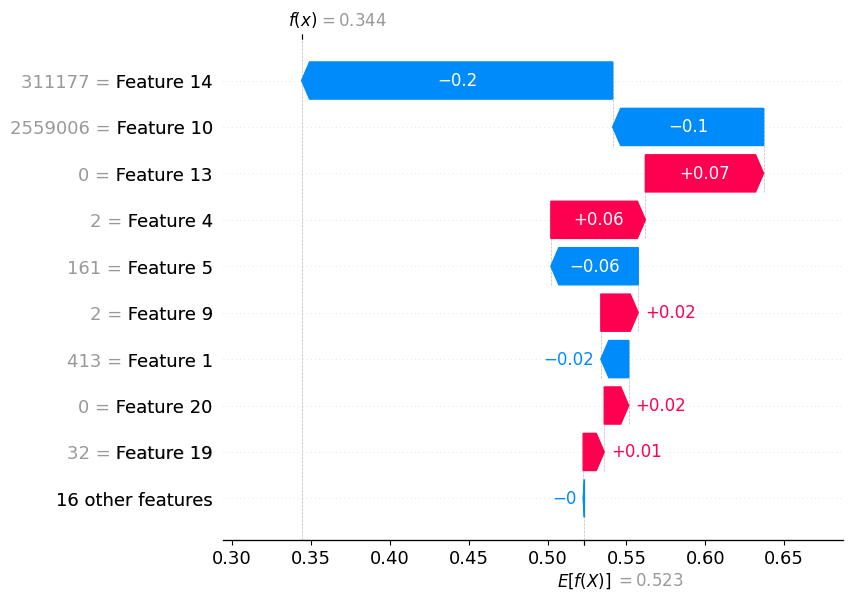

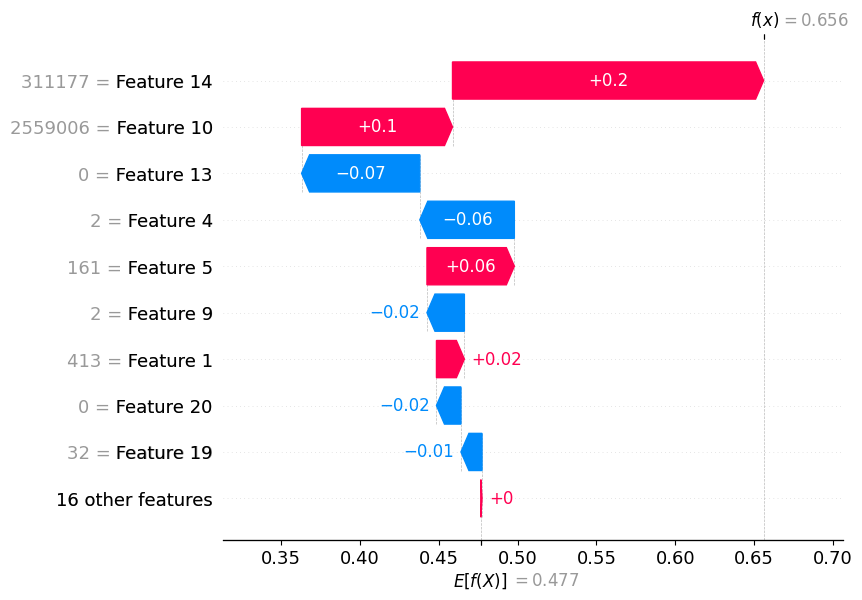

In [131]:
explainer = shap.Explainer(rf_model, X_resampled)

shap_values = explainer(test_x)

shap.plots.waterfall(shap.Explanation(
    values=shap_values.values[0][:, 1],
    base_values=shap_values.base_values[0][1],
    data=shap_values.data[0],
    feature_names=shap_values.feature_names
))

shap.plots.waterfall(shap.Explanation(
    values=shap_values.values[0][:, 0],
    base_values=shap_values.base_values[0][0],
    data=shap_values.data[0],
    feature_names=shap_values.feature_names
))

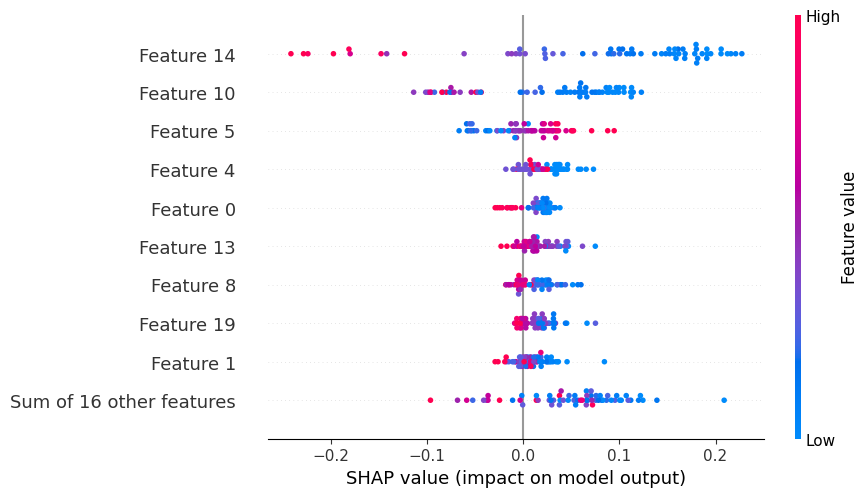

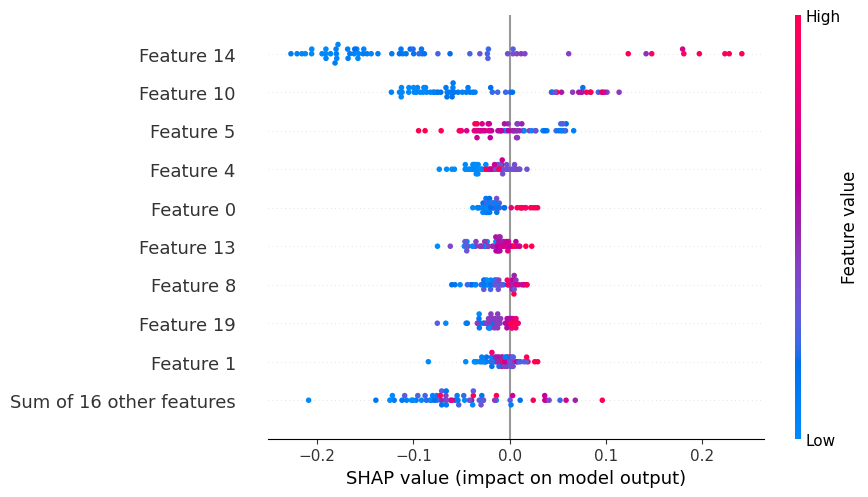

In [132]:
shap.plots.beeswarm(shap.Explanation(
    values=shap_values.values[:, :, 1],              
    base_values=shap_values.base_values[:, 1],       
    data=shap_values.data,                           
    feature_names=shap_values.feature_names       
))

shap.plots.beeswarm(shap.Explanation(
    values=shap_values.values[:, :, 0],
    base_values=shap_values.base_values[:, 0],
    data=shap_values.data,
    feature_names=shap_values.feature_names
))


## XGBoost

In [133]:
xgb_model = XGBClassifier(
    n_estimators=100,
    max_depth=10,
    learning_rate=0.005,
    subsample=0.9,
    colsample_bytree=0.8,
    eval_metric='logloss'
)

xgb_model.fit(X_resampled, y_resampled)

probs = xgb_model.predict_proba(test_x)
preds = xgb_model.predict(test_x)

print("Evaluation:")
print(f"Accuracy: {accuracy_score(test_y, preds):.4f}")
print(f"F1 Score (macro): {f1_score(test_y, preds, average='macro'):.4f}")
print(f"F1 Score (weighted): {f1_score(test_y, preds, average='weighted'):.4f}")

Evaluation:
Accuracy: 0.8125
F1 Score (macro): 0.7500
F1 Score (weighted): 0.7891


In [134]:
print("\nPer-Class Classification Report:")
print(classification_report(test_y, preds, digits=4))

print("Confusion Matrix:")
print(confusion_matrix(test_y, preds))



Per-Class Classification Report:
              precision    recall  f1-score   support

           0     1.0000    0.4545    0.6250        22
           1     0.7778    1.0000    0.8750        42

    accuracy                         0.8125        64
   macro avg     0.8889    0.7273    0.7500        64
weighted avg     0.8542    0.8125    0.7891        64

Confusion Matrix:
[[10 12]
 [ 0 42]]


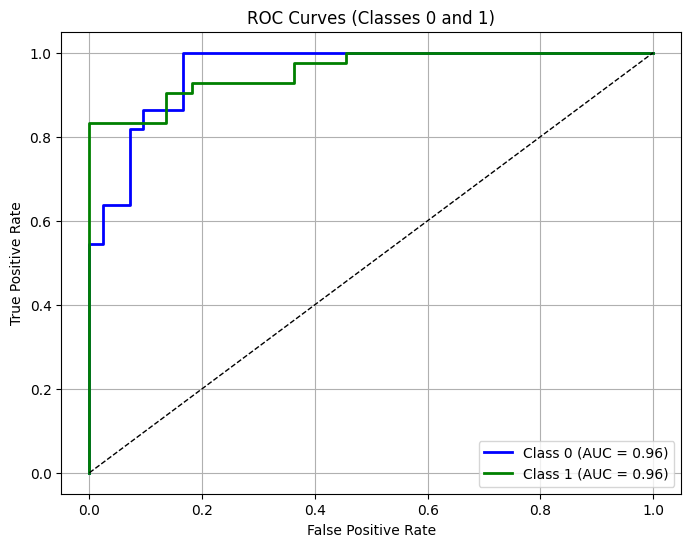

In [135]:
y_bin = label_binarize(test_y, classes=[0, 1])
if y_bin.shape[1] == 1:
    y_bin = np.hstack((1 - y_bin, y_bin))
fpr = {}
tpr = {}
roc_auc = {}

for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(y_bin[:, i], probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
colors = ['blue', 'green']
for i, color in zip(range(2), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f"Class {i} (AUC = {roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves (Classes 0 and 1)")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


Waterfall plot for predicted class 0 (index 0):


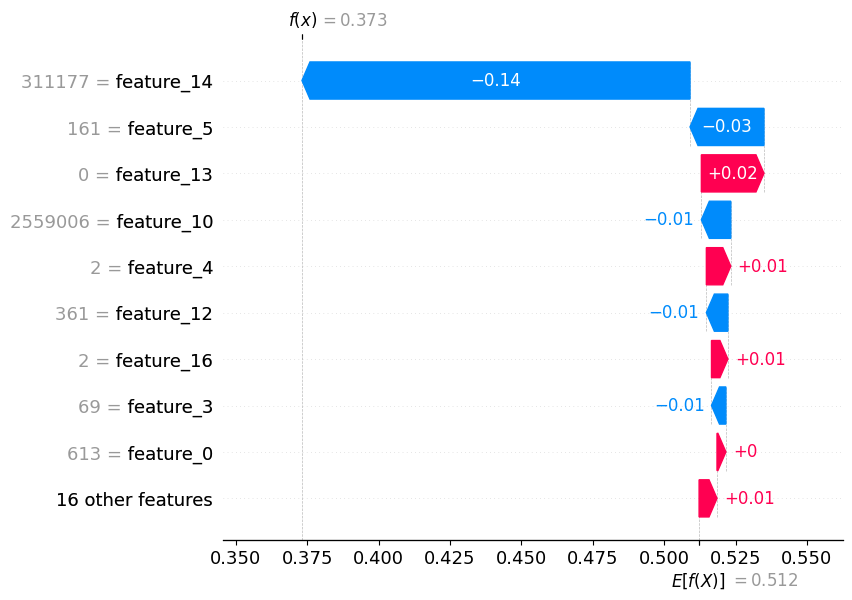

Waterfall plot for predicted class 1 (index 1):


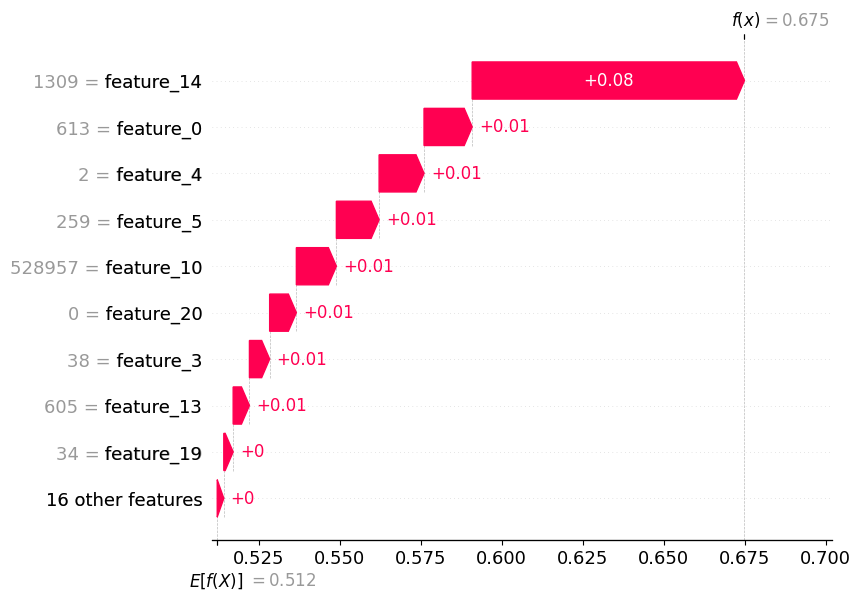

In [136]:
explainer = shap.TreeExplainer(xgb_model, X_resampled, feature_perturbation="interventional", model_output="probability")
shap_values = explainer.shap_values(test_x)

preds = xgb_model.predict(test_x)

idx_class_0 = np.where(preds == 0)[0][0]
idx_class_1 = np.where(preds == 1)[0][0]

feature_names = X_resampled.columns if hasattr(X_resampled, 'columns') else [f"feature_{i}" for i in range(test_x.shape[1])]

print(f"Waterfall plot for predicted class 0 (index {idx_class_0}):")
shap.plots.waterfall(shap.Explanation(
    values=shap_values[idx_class_0],
    base_values=explainer.expected_value,
    data=test_x[idx_class_0],
    feature_names=feature_names
))

print(f"Waterfall plot for predicted class 1 (index {idx_class_1}):")
shap.plots.waterfall(shap.Explanation(
    values=shap_values[idx_class_1],
    base_values=explainer.expected_value,
    data=test_x[idx_class_1],
    feature_names=feature_names
))


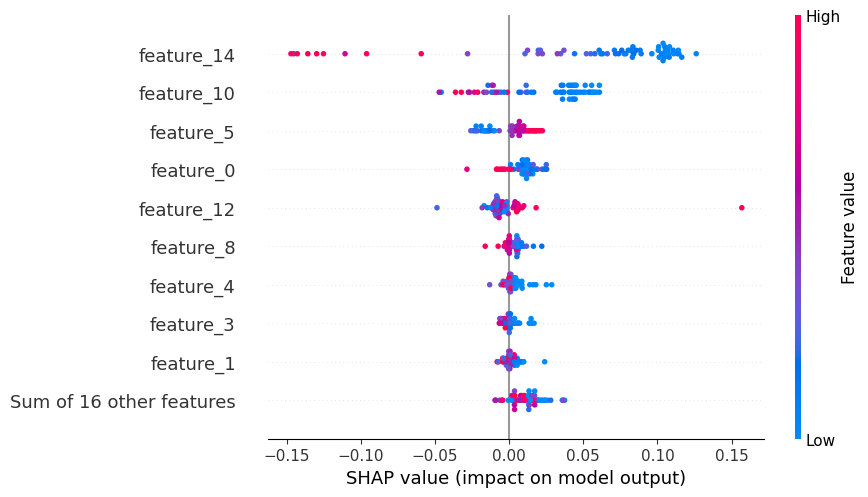

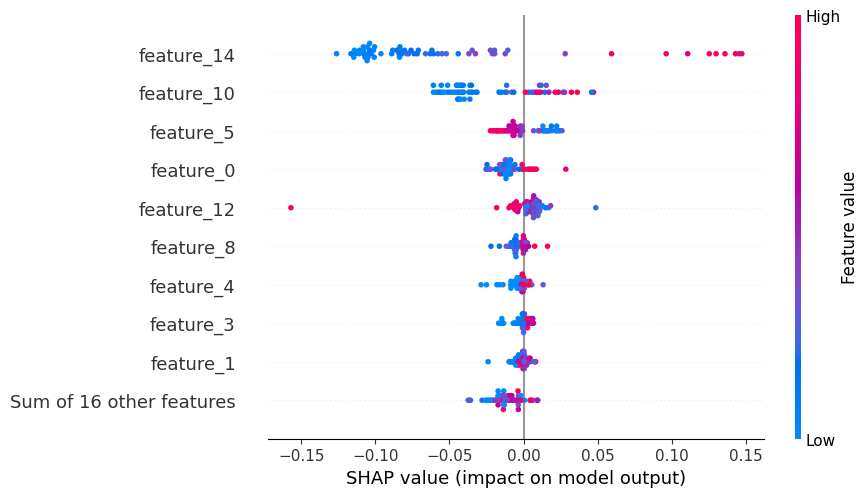

In [137]:
shap.plots.beeswarm(shap.Explanation(
    values=shap_values,
    base_values=np.repeat(explainer.expected_value, shap_values.shape[0]),
    data=test_x,
    feature_names=feature_names
))
shap_values_class_0 = -shap_values

shap.plots.beeswarm(shap.Explanation(
    values=shap_values_class_0,
    base_values=np.repeat(1 - explainer.expected_value, shap_values.shape[0]),
    data=test_x,
    feature_names=feature_names
))


In [138]:
# === Predict on full unlabeled set ===
unlabeled_probs = rf_model.predict_proba(unlabeled_x)
unlabeled_preds = rf_model.predict(unlabeled_x)
confidence_threshold = 0.95

final_unlabeled_preds = np.array([
    p if max(prob) >= confidence_threshold else 2
    for p, prob in zip(unlabeled_preds, unlabeled_probs)
])

# === Print stats ===
distribution = Counter(final_unlabeled_preds)
total = len(final_unlabeled_preds)
print("\nFinal Unlabeled Predictions Distribution:")
for label, count in distribution.items():
    pct = (count / total) * 100
    print(f"Class {label}: {count} ({pct:.2f}%)")



Final Unlabeled Predictions Distribution:
Class 2: 10467448 (79.65%)
Class 1: 2599954 (19.78%)
Class 0: 74219 (0.56%)


In [139]:
def postprocess_class1_sequences(unlabeled_x, unlabeled_y, unlabeled_meta, time_gap_threshold_us=5_000_000):
    feature_column_names = [
        'ClksThisMin', 'NofClx', 'medianKHz', 'avSPL', 'avPkAt',
        'AvPRF', 'avEndF', 'tWUTrisk', 'nActualClx', 'nRisingIPIs',
        'TrDur_us', 'nICIrising',
        'MinICI_us', 'midpointICI', 'MaxICI_us', 'ClkNofMinICI',
        'ClkNofMaxICI', 'NofClstrs',
        'avClstrNx8', 'avPkIPI', 'BeforeIPIratio', 'PreIPIratio',
        'Post1IPIratio', 'Post2IPIratio', 'EndIPIratio'
    ]
    trdur_idx =  feature_column_names.index('TrDur_us') 
    
    data_by_location = defaultdict(list)
    for idx, meta in enumerate(unlabeled_meta):
        location, minute_str, micro_str = meta
        start_us = np.int64(int(minute_str)) * 60 * 1_000_000 + np.int64(int(micro_str))
        duration_us = np.int64(unlabeled_x[idx, trdur_idx])
        end_us = start_us + duration_us
        data_by_location[location].append((start_us, end_us, idx))
    for loc in data_by_location:
        data_by_location[loc].sort()
    new_labels = unlabeled_y.copy()
    
    for loc, entries in data_by_location.items():
        class1_entries = [(s, e, i) for (s, e, i) in entries if unlabeled_y[i] == 1]
        class1_entries.sort()
        
        current_sequence = []
        for j in range(len(class1_entries)):
            s, e, idx = class1_entries[j]
            if not current_sequence:
                current_sequence.append((s, e, idx))
            else:
                prev_s, prev_e, _ = current_sequence[-1]
                if s - prev_e <= time_gap_threshold_us:
                    current_sequence.append((s, e, idx))
                else:
                    if len(current_sequence) >= 2:
                        for _, _, seq_idx in current_sequence:
                            new_labels[seq_idx] = 1
                    else:
                        for _, _, seq_idx in current_sequence:
                            new_labels[seq_idx] = 2
                    current_sequence = [(s, e, idx)]
        
        if current_sequence:
            if len(current_sequence) >= 2:
                for _, _, seq_idx in current_sequence:
                    new_labels[seq_idx] = 1
            else:
                for _, _, seq_idx in current_sequence:
                    new_labels[seq_idx] = 2
                    
    return new_labels

new_labels = postprocess_class1_sequences(unlabeled_x, final_unlabeled_preds, unlabeled_meta)

In [140]:
distribution = Counter(new_labels)
total = len(new_labels)
print("\nFinal Unlabeled Predictions Distribution:")
for label, count in distribution.items():
    pct = (count / total) * 100
    print(f"Class {label}: {count} ({pct:.2f}%)")


Final Unlabeled Predictions Distribution:
Class 2: 11585140 (88.16%)
Class 1: 1482262 (11.28%)
Class 0: 74219 (0.56%)


In [2]:
class AcousticSequenceDataset(Dataset):
    def __init__(self, data_dir, excel_path=None, target_length=128, click_filter=None,
                 id_columns=('File', 'Minute', 'Time')):
        self.data_dir = data_dir
        self.target_length = target_length
        self.click_filter = click_filter
        self.id_columns = id_columns
        self.label_encoder = LabelEncoder()

        self.labeled_timeseries = []
        self.identities = []
        self.labels_for_labeled_data = []

        self.labeled_data = pd.DataFrame()
        self.labels = []
        self.labeled_indices = set()
        self.identity_to_label = {}

        if excel_path:
            self._load_labeled_data(excel_path)

        self.unlabeled_sequences, self.unlabeled_metadata = self._load_and_process_files()

    def _load_labeled_data(self, excel_path):
        xl = pd.ExcelFile(excel_path)
        dfs = []
        for sheet in xl.sheet_names:
            df = xl.parse(sheet)
            df['label'] = sheet  
            dfs.append(df)
        full_labeled = pd.concat(dfs, ignore_index=True)

        full_labeled[self.id_columns[0]] = full_labeled[self.id_columns[0]].astype(str)
        full_labeled[self.id_columns[1]] = full_labeled[self.id_columns[1]].astype(int)
        full_labeled[self.id_columns[2]] = full_labeled[self.id_columns[2]].astype(int)

        self.labeled_data = full_labeled
        self.labels = self.label_encoder.fit_transform(full_labeled['label'])
        self.labeled_indices = set(full_labeled[list(self.id_columns)].apply(tuple, axis=1))

        self.identity_to_label = {
            tuple(row[col] for col in self.id_columns): label
            for row, label in zip(full_labeled.to_dict(orient="records"), self.labels)
        }

    def _load_and_process_files(self):
        sequences = []
        metadata = []

        for file in os.listdir(self.data_dir):
            path = os.path.join(self.data_dir, file)
            try:
                df = pd.read_csv(path, sep="\t", usecols=['Minute', 'microsec', 'ICI', 'File'])
            except Exception as e:
                print(f"Failed to read {file}: {e}")
                continue
            if df.empty:
                continue
            file_name = df['File'][0]
            df["Datetime"] = datetime(1899, 12, 30) + pd.to_timedelta(df["Minute"], unit="m") + pd.to_timedelta(
                df["microsec"], unit="us")
            df["Clk/s"] = (1 / df["ICI"]) * 10 ** 6

            df.drop(columns=['File'], inplace=True)
            df['Datetime'] = pd.to_datetime(df['Datetime'])
            df.set_index('Datetime', inplace=True)

            clk_values = df['Clk/s'].values
            is_inf = np.isinf(clk_values)
            split_indices = np.where(is_inf)[0]
            start_idx = 0
            for end_idx in split_indices:
                instance = df.iloc[start_idx:end_idx]

                if len(instance) < 3:
                    start_idx = end_idx + 1
                    continue

                if self.click_filter and not self.click_filter(instance):
                    start_idx = end_idx + 1
                    continue

                if start_idx > 0:
                    anchor_row = df.iloc[start_idx - 1]
                    minute = int(anchor_row['Minute'])
                    microsec = int(anchor_row['microsec'])
                else:
                    minute = int(df['Minute'].iloc[start_idx])
                    microsec = int(df['microsec'].iloc[start_idx])

                if instance.isnull().all().any():
                    start_idx = end_idx + 1
                    continue

                time_values = (instance.index - instance.index[0]).total_seconds().astype(np.float32)
                clk_values = instance['Clk/s'].values.astype(np.float32)

                if len(time_values) < 2 or np.all(time_values == time_values[0]):
                    start_idx = end_idx + 1
                    continue
                    
                identity = (file_name, minute, microsec)

                if identity in self.identity_to_label:
                    self.labeled_timeseries.append(clk_values)
                    self.identities.append(identity)
                    self.labels_for_labeled_data.append(self.identity_to_label[identity])
                else:
                    sequences.append(clk_values)
                    metadata.append(identity)

                start_idx = end_idx + 1

        return sequences, metadata

    def get_labeled(self):
        return (
            self.labeled_timeseries,
            np.array(self.labels_for_labeled_data, dtype=np.int64),
            self.labeled_data[list(self.id_columns)],
            np.array(self.identities),
        )

    def get_unlabeled(self):
        return self.unlabeled_sequences, self.unlabeled_metadata

    def __len__(self):
        return len(self.labeled_timeseries)

    def __getitem__(self, idx):
        return self.labeled_timeseries[idx]

click_dataset = AcousticSequenceDataset(
    'data_files/unlabeled_data',
    excel_path="data_files/datasets/CLICK TRAINS.xlsx",
    target_length=64,
    click_filter=None,
    id_columns=('File', 'Minute', 'Time')
)

# signal_x, signal_meta = click_dataset.get_unlabeled()

In [8]:
# labeled_sx, labeled_sy, _,  labeled_smeta = click_dataset.get_labeled()

In [143]:
data = np.load("fixed_click_dataset.npz", allow_pickle=True)
labeled_sx = data['labeled_x']
labeled_sy = data['labeled_y']
signal_x = data['unlabeled_x']
signal_meta = data['unlabeled_meta']
labeled_smeta = data['labeled_meta']

In [18]:
# np.savez("fixed_click_dataset.npz", 
#          labeled_x=labeled_x,
#          labeled_y=labeled_y,
#          labeled_meta=meta_signal,
#          unlabeled_x=unlabeled_x,
#          unlabeled_meta=unlabeled_meta)

In [145]:
special_areas = ['U Dzha Bay', 'U Dzha Sea']

signal_meta = np.array(signal_meta)
def extract_area_name(entry):
    entry_str = str(entry)
    for area in special_areas:
        if entry_str.startswith(area):
            return area
    match = re.match(r'^(\w+ \w+)', entry_str)
    return match.group(1) if match else entry_str

vectorized_extractor = np.vectorize(extract_area_name)

clean_unlabeled_meta = vectorized_extractor(signal_meta[:, 0])
meta_signal = np.column_stack((clean_unlabeled_meta, signal_meta[:, 1:3]))

In [147]:
print(unlabeled_x[0], final_unlabeled_preds[0], unlabeled_meta[0])
print(signal_x[0], meta_signal[0])

[3.21000e+02 1.40000e+01 1.25000e+02 6.50000e+01 3.00000e+00 2.10000e+01
 1.30000e+02 0.00000e+00 1.40000e+01 2.00000e+00 6.19047e+05 4.00000e+00
 7.72700e+03 8.46400e+03 1.20530e+04 1.10000e+01 1.40000e+01 1.40000e+01
 8.00000e+00 3.20000e+01 2.16000e+00 9.90000e-01 1.02000e+00 1.05000e+00
 1.04000e+00] 2 ['B Balchik' '63575465' '29060110']
[19.958088 19.946428 19.93477  19.923111 19.911453 19.899794 19.888136
 19.876476 19.864819 19.85316  19.841501 19.829844 19.818184 19.806526
 19.794867 19.783207 19.77155  19.781403 19.820837 19.860271 19.899706
 19.93914  19.978575 20.01801  20.057444 20.096878 20.136312 20.175747
 20.215181 20.254616 20.29405  20.333485 20.37292  20.412354 20.521284
 20.643242 20.765202 20.88716  21.009119 21.131077 21.253035 21.374994
 21.496954 21.618912 21.740871 21.86283  21.984787 22.068106 22.123322
 22.17854  22.233755 22.288973 22.34419  22.399406 22.454624 22.50984
 22.565056 22.620274 22.67549  22.730705 22.785923 22.841139 22.896357
 22.951572] ['B Ba

In [148]:
def save_labeled_visuals_by_location(
    labeled_x, labeled_y, labeled_meta,
    signal_x, signal_meta,
    location_filter='U Dzha Bay',
    save_dir='labeled_data_visuals',
    save_waveform_plot=True,
    max_per_class=30
):
    os.makedirs(save_dir, exist_ok=True)

    feature_column_names = [
        'ClksThisMin', 'NofClx', 'medianKHz', 'avSPL', 'avPkAt',
        'AvPRF', 'avEndF', 'tWUTrisk', 'nActualClx', 'nRisingIPIs',
        'TrDur_us', 'nICIrising',
        'MinICI_us', 'midpointICI', 'MaxICI_us', 'ClkNofMinICI',
        'ClkNofMaxICI', 'NofClstrs',
        'avClstrNx8', 'avPkIPI', 'BeforeIPIratio', 'PreIPIratio',
        'Post1IPIratio', 'Post2IPIratio', 'EndIPIratio'
    ]

    class_dirs = {
        0: os.path.join(save_dir, "class_0"),
        1: os.path.join(save_dir, "class_1"),
        2: os.path.join(save_dir, "noise")
    }
    for d in class_dirs.values():
        os.makedirs(d, exist_ok=True)

    filtered = [
        (x, y, meta) for x, y, meta in zip(labeled_x, labeled_y, labeled_meta)
        if meta[0] == location_filter
    ]

    if not filtered:
        print(f"No labeled instances found for location: {location_filter}")
        return

    signal_lookup = {tuple(m): s for s, m in zip(signal_x, signal_meta)}
    saved_counts = {0: 0, 1: 0, 2: 0}

    for i, (x, y, meta) in enumerate(tqdm(filtered)):
        identity = tuple([meta[0], int(meta[1]), int(meta[2])])
        raw_signal = signal_lookup.get(identity, None)

        if raw_signal is None:
            continue

        final_class = y if y in [0, 1] else 2
        if saved_counts[final_class] >= max_per_class:
            continue

        label_dir = class_dirs[final_class]
        base_name = f"{i}_{identity[0].replace(' ', '_')}_{identity[1]}_{identity[2]}"

        df_feat = pd.DataFrame([x], columns=feature_column_names)
        df_feat.to_csv(os.path.join(label_dir, f"{base_name}_features.csv"), index=False)

        if save_waveform_plot:
            plt.figure(figsize=(6, 3))
            plt.plot(raw_signal, lw=1)
            plt.title(f"Label: Class {final_class}")
            plt.xlabel("Time (sampled)")
            plt.ylabel("Clk/s")
            plt.tight_layout()
            plt.savefig(os.path.join(label_dir, f"{base_name}_waveform.png"))
            plt.close()

        saved_counts[final_class] += 1

        if all(saved_counts[c] >= max_per_class for c in saved_counts):
            print("Saved max limit for all classes. Stopping.")
            break

    print(f"Saved labeled data for location: {location_filter} to: {save_dir}")
    print(f"Saved counts: {saved_counts}")
    
save_labeled_visuals_by_location(
    unlabeled_x, final_unlabeled_preds, unlabeled_meta,
    signal_x, meta_signal,
    location_filter='U Kinburn',
    save_dir='data_files/Kinburn_data_visuals',
    save_waveform_plot=True,
    max_per_class=100
)

 15%|█▍        | 16498/110321 [00:43<04:09, 375.51it/s] 

Saved max limit for all classes. Stopping.
Saved labeled data for location: U Kinburn to: Kinburn_data_visuals
Saved counts: {0: 100, 1: 100, 2: 100}
